# Experiment 16: Prefix Composition

**Hypothesis:** The optimal prefix combines semantic signal (from oracle queries) with structural noise (from random queries). A mix captures both benefits while avoiding semantic interference.

**Motivation from Exp 15:**
- Oracle helps 91 pages, hurts 33 pages (net +58)
- Random helps 100 pages, hurts 24 pages (net +76) — better net effect!
- 6 pages where oracle actively hurts but random helps
- Random provides "regularization" that prevents over-focusing

**Design:**
- Self-contained: creates own ranking task (500 pages × 10 ads)
- Test mix ratios: 5:0, 4:1, 3:2, 2:3, 1:4, 0:5 (oracle:random)
- Test interleaved vs concatenated ordering
- ~35,000 forward passes (500 pages × 10 ads × 7 conditions)

In [1]:
# Cell 1: Setup
import os
os.umask(0o000)  # World-writable files for jupyter/CLI compatibility

import json
import copy
import random
import warnings
import time
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

import numpy as np
import torch
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Monkey-patch json to handle numpy types globally
_original_default = json.JSONEncoder.default
def _numpy_default(self, obj):
    if isinstance(obj, (np.bool_, np.integer)):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return _original_default(self, obj)
json.JSONEncoder.default = _numpy_default

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Paths
PROJECT_ROOT = Path('/home/jupyter/research/directed_kvcache')
RESULTS_DIR = PROJECT_ROOT / 'results' / 'exp16'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Config
@dataclass
class Config:
    model_name: str = 'mistralai/Mistral-7B-Instruct-v0.2'
    checkpoint_every: int = 25
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()
print(f"Config: {config}")
print(f"Results will be saved to: {RESULTS_DIR}")

Config: Config(model_name='mistralai/Mistral-7B-Instruct-v0.2', checkpoint_every=25, device='cuda')
Results will be saved to: /home/jupyter/research/directed_kvcache/results/exp16


In [2]:
# Cell 2: Load Model and Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DynamicCache

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Loading model (4-bit quantization)...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
model.eval()
print(f"Model loaded on {config.device}")

Loading tokenizer...
Loading model (4-bit quantization)...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda


In [3]:
# Cell 3: Helper Functions (DynamicCache-native)
import copy
import torch
import torch.nn.functional as F
from typing import Tuple, List, Dict, Optional
from transformers import DynamicCache

def apply_rope_correction(keys: torch.Tensor, shift: int, head_dim: int, start_pos: int = 0) -> torch.Tensor:
    """
    Apply RoPE position correction to keys.
    Uses half-split pairing (not interleaved) to match HuggingFace rotate_half.
    Preserves input dtype (critical for float16).
    """
    dtype = keys.dtype
    device = keys.device
    seq_len = keys.shape[2]

    positions = torch.arange(start_pos, start_pos + seq_len, device=device)
    dim_half = head_dim // 2
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim_half, device=device).float() / dim_half))

    freqs = torch.outer(positions, inv_freq)
    cos = torch.cos(freqs * shift).to(dtype)
    sin = torch.sin(freqs * shift).to(dtype)

    # Half-split (matches HuggingFace rotate_half)
    k1 = keys[..., :dim_half]
    k2 = keys[..., dim_half:]

    k1_new = k1 * cos - k2 * sin
    k2_new = k2 * cos + k1 * sin

    return torch.cat([k1_new, k2_new], dim=-1)


def extract_and_correct_cache(cache: DynamicCache, keep_bos: bool, prefix_len: int, head_dim: int) -> DynamicCache:
    """
    Extract passage portion from full cache and apply RoPE correction.
    """
    new_cache = DynamicCache()

    for layer_idx, (k, v, _) in enumerate(cache):
        if keep_bos:
            bos_k, bos_v = k[:, :, :1, :], v[:, :, :1, :]
            passage_k = k[:, :, prefix_len:, :]
            passage_v = v[:, :, prefix_len:, :]
            corrected_k = apply_rope_correction(passage_k, -prefix_len, head_dim, start_pos=prefix_len)
            new_k = torch.cat([bos_k, corrected_k], dim=2)
            new_v = torch.cat([bos_v, passage_v], dim=2)
        else:
            passage_k = k[:, :, prefix_len:, :]
            passage_v = v[:, :, prefix_len:, :]
            new_k = apply_rope_correction(passage_k, -prefix_len, head_dim, start_pos=prefix_len)
            new_v = passage_v

        new_cache.update(new_k, new_v, layer_idx)

    return new_cache


def build_bare_cache(passage: str, tokenizer, model) -> Tuple[DynamicCache, int]:
    """Build a simple bare cache for a passage. Returns (DynamicCache, seq_len)."""
    ids = tokenizer.encode(passage, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model(ids, use_cache=True)
    return out.past_key_values, ids.shape[1]


def build_primed_cache(passage: str, prefix: str, tokenizer, model) -> Tuple[DynamicCache, int]:
    """
    Build a primed cache: forward pass through prefix+passage, keep full cache.
    (No truncation/RoPE correction - we keep the full primed context)
    Returns (DynamicCache, seq_len).
    """
    full_text = prefix + " " + passage if prefix else passage
    full_ids = tokenizer.encode(full_text, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        full_out = model(full_ids, use_cache=True)
    
    return full_out.past_key_values, full_ids.shape[1]


def deepcopy_cache(cache: DynamicCache) -> DynamicCache:
    """
    Deep copy a DynamicCache.
    Uses clone() on tensors to ensure true copy.
    """
    new_cache = DynamicCache()
    for layer_idx, (k, v, _) in enumerate(cache):
        new_cache.update(k.clone(), v.clone(), layer_idx)
    return new_cache


def score_answer_with_cache(cache: DynamicCache, query: str, answer: str, tokenizer, model, seq_len: int) -> float:
    """
    Score an answer given a pre-built cache and query.
    Returns mean NLL over answer tokens.

    IMPORTANT: cache is used in-place by the model. Use deepcopy_cache() before calling if reusing.
    """
    # Format continuation
    continuation = f"Query: {query}\nAnswer: {answer}"
    cont_ids = tokenizer.encode(continuation, return_tensors='pt', add_special_tokens=False).to(model.device)

    # Find answer token count
    answer_only = f" {answer}"
    answer_ids = tokenizer.encode(answer_only, return_tensors='pt', add_special_tokens=False)
    answer_len = answer_ids.shape[1]

    with torch.no_grad():
        position_ids = torch.arange(seq_len, seq_len + cont_ids.shape[1], device=model.device).unsqueeze(0)

        outputs = model(
            input_ids=cont_ids,
            past_key_values=cache,
            position_ids=position_ids,
            use_cache=True,
        )

        logits = outputs.logits[0]  # [seq_len, vocab]
        total_len = cont_ids.shape[1]

        # Answer tokens are the last answer_len tokens
        answer_logits = logits[total_len - answer_len - 1 : total_len - 1, :]  # Predict next token
        answer_targets = cont_ids[0, total_len - answer_len:]

        loss = F.cross_entropy(answer_logits, answer_targets, reduction='mean')

    return loss.item()


def compute_ranking_metrics(page: dict, scores: Dict[int, float]) -> dict:
    """Compute MRR, Hit@K, NDCG given scores."""
    ranked = sorted(scores.items(), key=lambda x: x[1])
    ranked_ids = [idx for idx, _ in ranked]
    
    relevant_rank = ranked_ids.index(0) + 1
    
    mrr = 1.0 / relevant_rank if relevant_rank <= 10 else 0.0
    hit_at_1 = 1.0 if relevant_rank == 1 else 0.0
    hit_at_3 = 1.0 if relevant_rank <= 3 else 0.0
    hit_at_10 = 1.0 if relevant_rank <= 10 else 0.0
    
    dcg = 1.0 / np.log2(relevant_rank + 1) if relevant_rank <= 10 else 0.0
    ndcg = dcg / 1.0
    
    return {
        'mrr': mrr,
        'hit_at_1': hit_at_1,
        'hit_at_3': hit_at_3,
        'hit_at_10': hit_at_10,
        'ndcg_at_10': ndcg,
        'relevant_rank': relevant_rank,
        'relevant_nll': scores[0]
    }

print("Helper functions defined (DynamicCache-native).")

Helper functions defined (DynamicCache-native).


In [4]:
# Cell 4: Load MS MARCO Data and Create Ranking Task

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

print("Loading MS MARCO dataset...")
dataset = load_dataset("ms_marco", "v1.1", split="train")

# Filter for valid samples with answers
print("Filtering samples...")
valid_samples = []
for i, sample in enumerate(dataset):
    if len(valid_samples) >= 5000:
        break
    
    # Need a selected passage and well-formed answer
    passages = sample.get('passages', {})
    is_selected = passages.get('is_selected', [])
    passage_texts = passages.get('passage_text', [])
    
    if not any(is_selected) or not passage_texts:
        continue
    
    # Get the selected passage
    selected_idx = is_selected.index(1) if 1 in is_selected else 0
    passage = passage_texts[selected_idx]
    
    # Check answer
    answers = sample.get('answers', [])
    if not answers or answers[0] == 'No Answer Present.':
        continue
    
    answer = answers[0]
    query = sample.get('query', '')
    
    # Basic length filters
    if len(passage.split()) < 20 or len(passage.split()) > 500:
        continue
    if len(answer.split()) < 3:
        continue
    
    valid_samples.append({
        'passage': passage,
        'query': query,
        'answer': answer,
        'idx': i
    })

print(f"Loaded {len(valid_samples)} valid samples")

# Config for ranking task
N_PAGES = 500
N_ADS_PER_PAGE = 10
N_EASY = 3    # sim 0.0-0.2
N_MEDIUM = 3  # sim 0.2-0.4
N_HARD = 3    # sim 0.4-0.6

# Load embedding model for distractor selection
print("Loading embedding model...")
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Compute query embeddings
print("Computing query embeddings...")
queries = [s['query'] for s in valid_samples]
query_embeddings = embed_model.encode(queries, normalize_embeddings=True, show_progress_bar=True)

# Compute similarity matrix
print("Computing similarity matrix...")
similarity_matrix = query_embeddings @ query_embeddings.T

# Create ranking task
print("Creating ranking task...")
ranking_task = []

for page_idx in range(len(valid_samples)):
    if len(ranking_task) >= N_PAGES:
        break
        
    sample = valid_samples[page_idx]
    sims = similarity_matrix[page_idx]
    
    # Find distractors at different similarity levels
    easy_mask = (sims >= 0.0) & (sims < 0.2) & (np.arange(len(sims)) != page_idx)
    medium_mask = (sims >= 0.2) & (sims < 0.4) & (np.arange(len(sims)) != page_idx)
    hard_mask = (sims >= 0.4) & (sims < 0.6) & (np.arange(len(sims)) != page_idx)
    
    easy_candidates = np.where(easy_mask)[0]
    medium_candidates = np.where(medium_mask)[0]
    hard_candidates = np.where(hard_mask)[0]
    
    # Skip if not enough distractors
    if len(easy_candidates) < N_EASY or len(medium_candidates) < N_MEDIUM or len(hard_candidates) < N_HARD:
        continue
    
    # Sample distractors
    random.seed(SEED + page_idx)
    easy_distractors = random.sample(list(easy_candidates), N_EASY)
    medium_distractors = random.sample(list(medium_candidates), N_MEDIUM)
    hard_distractors = random.sample(list(hard_candidates), N_HARD)
    
    # Build ads list: relevant ad first (index 0), then distractors
    ads = [{
        'query': sample['query'],
        'answer': sample['answer'],
        'is_relevant': True,
        'similarity': 1.0
    }]
    
    for dist_idx in easy_distractors + medium_distractors + hard_distractors:
        dist_sample = valid_samples[dist_idx]
        ads.append({
            'query': dist_sample['query'],
            'answer': dist_sample['answer'],
            'is_relevant': False,
            'similarity': float(sims[dist_idx])
        })
    
    ranking_task.append({
        'page_idx': page_idx,
        'passage': sample['passage'],
        'ground_truth_query': sample['query'],
        'ads': ads
    })

print(f"Created ranking task with {len(ranking_task)} pages, {N_ADS_PER_PAGE} ads each")

# Save ranking task
with open(RESULTS_DIR / '16_ranking_task.json', 'w') as f:
    json.dump(ranking_task, f, indent=2)
print(f"Saved ranking task to {RESULTS_DIR / '16_ranking_task.json'}")

Loading MS MARCO dataset...
Filtering samples...
Loaded 5000 valid samples
Loading embedding model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Computing query embeddings...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Computing similarity matrix...
Creating ranking task...
Created ranking task with 500 pages, 10 ads each
Saved ranking task to /home/jupyter/research/directed_kvcache/results/exp16/16_ranking_task.json


In [5]:
# Cell 5: Define Prefix Composition Strategies

def build_mixed_prefix(semantic_query: str, random_queries: List[str], 
                       n_semantic: int, n_random: int, 
                       interleaved: bool = False) -> str:
    """
    Build a mixed prefix with semantic and random queries.
    
    Args:
        semantic_query: The semantic (oracle) query to repeat
        random_queries: List of random queries to use
        n_semantic: Number of times to repeat semantic query
        n_random: Number of random queries to include
        interleaved: If True, alternate semantic/random; if False, concatenate
    """
    if interleaved and n_semantic > 0 and n_random > 0:
        # Interleave: s, r, s, r, s, ...
        parts = []
        for i in range(max(n_semantic, n_random)):
            if i < n_semantic:
                parts.append(semantic_query)
            if i < n_random:
                parts.append(random_queries[i % len(random_queries)])
        return ' '.join(parts)
    else:
        # Concatenate: semantic first, then random
        semantic_part = ' '.join([semantic_query] * n_semantic) if n_semantic > 0 else ''
        random_part = ' '.join(random_queries[:n_random]) if n_random > 0 else ''
        return (semantic_part + ' ' + random_part).strip()


def get_random_queries(page_idx: int, n: int, samples: List) -> List[str]:
    """Get n random queries different from the current page."""
    random.seed(SEED + page_idx)  # Reproducible per page
    candidates = [s['query'] for i, s in enumerate(samples) if i != page_idx]
    return random.sample(candidates, min(n, len(candidates)))


# Define composition conditions (oracle vs random mixes)
COMPOSITIONS = [
    # Name, n_semantic (oracle), n_random, interleaved
    ('oracle_5_0', 5, 0, False),          # Pure oracle 5x
    ('oracle_4_1', 4, 1, False),          # 4 oracle + 1 random
    ('oracle_3_2', 3, 2, False),          # 3 oracle + 2 random
    ('oracle_2_3', 2, 3, False),          # 2 oracle + 3 random
    ('oracle_1_4', 1, 4, False),          # 1 oracle + 4 random
    ('random_0_5', 0, 5, False),          # Pure random 5x
    ('oracle_interleaved', 3, 2, True),   # 3 oracle + 2 random, interleaved
]

print(f"Defined {len(COMPOSITIONS)} composition conditions:")
for name, n_sem, n_rand, interleaved in COMPOSITIONS:
    mode = 'interleaved' if interleaved else 'concat'
    print(f"  {name}: {n_sem} oracle + {n_rand} random ({mode})")

Defined 7 composition conditions:
  oracle_5_0: 5 oracle + 0 random (concat)
  oracle_4_1: 4 oracle + 1 random (concat)
  oracle_3_2: 3 oracle + 2 random (concat)
  oracle_2_3: 2 oracle + 3 random (concat)
  oracle_1_4: 1 oracle + 4 random (concat)
  random_0_5: 0 oracle + 5 random (concat)
  oracle_interleaved: 3 oracle + 2 random (interleaved)


In [6]:
# Cell 6: Run Composition Experiment

print("Running prefix composition experiment...")

composition_results = {name: [] for name, _, _, _ in COMPOSITIONS}
checkpoint_path = RESULTS_DIR / '16_composition_checkpoint.json'
start_idx = 0

if checkpoint_path.exists():
    with open(checkpoint_path) as f:
        checkpoint = json.load(f)
    composition_results = checkpoint['data']
    start_idx = checkpoint['next_idx']
    print(f"Resuming from checkpoint at index {start_idx}")

for i, page in enumerate(ranking_task[start_idx:], start=start_idx):
    if i % config.checkpoint_every == 0:
        print(f"  Processing page {i}/{len(ranking_task)}...")
        with open(checkpoint_path, 'w') as f:
            json.dump({'data': composition_results, 'next_idx': i}, f)
    
    page_idx = page['page_idx']
    passage = page['passage']
    oracle_query = page['ground_truth_query']
    random_queries = get_random_queries(page_idx, 5, valid_samples)
    
    try:
        for comp_name, n_semantic, n_random, interleaved in COMPOSITIONS:
            # Build prefix
            prefix = build_mixed_prefix(oracle_query, random_queries, 
                                        n_semantic, n_random, interleaved)
            
            # Build cache
            if prefix:
                cache, seq_len = build_primed_cache(passage, prefix, tokenizer, model)
            else:
                cache, seq_len = build_bare_cache(passage, tokenizer, model)
            
            # Score all ads
            scores = {}
            for ad_idx, ad in enumerate(page['ads']):
                cache_copy = deepcopy_cache(cache)
                nll = score_answer_with_cache(cache_copy, ad['query'], ad['answer'], 
                                              tokenizer, model, seq_len)
                scores[ad_idx] = nll
            
            # Compute metrics
            metrics = compute_ranking_metrics(page, scores)
            
            composition_results[comp_name].append({
                'page_idx': page_idx,
                'metrics': metrics,
            })
    
    except Exception as e:
        print(f"  Error at page {i}: {e}")
        continue

# Final save
with open(checkpoint_path, 'w') as f:
    json.dump({'data': composition_results, 'next_idx': len(ranking_task)}, f)

print("\nExperiment complete!")

Running prefix composition experiment...
  Processing page 0/500...
  Processing page 25/500...
  Processing page 50/500...
  Processing page 75/500...
  Processing page 100/500...
  Processing page 125/500...
  Processing page 150/500...
  Processing page 175/500...
  Processing page 200/500...
  Processing page 225/500...
  Processing page 250/500...
  Processing page 275/500...
  Processing page 300/500...
  Processing page 325/500...
  Processing page 350/500...
  Processing page 375/500...
  Processing page 400/500...
  Processing page 425/500...
  Processing page 450/500...
  Processing page 475/500...

Experiment complete!


In [7]:
# Cell 7: Analyze Results

print("\n" + "="*70)
print("COMPOSITION EXPERIMENT RESULTS")
print("="*70)

# Compute aggregate metrics for each composition
summary = {}
for comp_name, _, _, _ in COMPOSITIONS:
    results = composition_results[comp_name]
    if not results:
        continue
    
    mrr = np.mean([r['metrics']['mrr'] for r in results])
    hit1 = np.mean([r['metrics']['hit_at_1'] for r in results])
    hit3 = np.mean([r['metrics']['hit_at_3'] for r in results])
    ndcg = np.mean([r['metrics']['ndcg_at_10'] for r in results])
    
    summary[comp_name] = {
        'mrr': mrr, 'hit_at_1': hit1, 'hit_at_3': hit3, 'ndcg': ndcg, 'n': len(results)
    }

# Sort by MRR
sorted_comps = sorted(summary.items(), key=lambda x: -x[1]['mrr'])

print(f"\n{'Composition':<25} {'MRR':<10} {'Hit@1':<10} {'Hit@3':<10} {'NDCG':<10}")
print("-" * 65)

for comp_name, metrics in sorted_comps:
    print(f"{comp_name:<25} {metrics['mrr']:<10.4f} {metrics['hit_at_1']:<10.4f} "
          f"{metrics['hit_at_3']:<10.4f} {metrics['ndcg']:<10.4f}")

# Find best composition
best_comp = sorted_comps[0]
print(f"\nBest composition: {best_comp[0]} (MRR={best_comp[1]['mrr']:.4f})")

# Compare to pure oracle and pure random
if 'oracle_5_0' in summary and 'random_0_5' in summary:
    pure_oracle_mrr = summary['oracle_5_0']['mrr']
    pure_random_mrr = summary['random_0_5']['mrr']
    best_mrr = best_comp[1]['mrr']
    
    print(f"\nComparison:")
    print(f"  Pure oracle (5:0): MRR={pure_oracle_mrr:.4f}")
    print(f"  Pure random (0:5): MRR={pure_random_mrr:.4f}")
    print(f"  Best mix ({best_comp[0]}): MRR={best_mrr:.4f}")
    
    if best_mrr > pure_oracle_mrr and best_mrr > pure_random_mrr:
        print(f"\n  >> MIXING HELPS! Best mix beats both pure strategies.")


COMPOSITION EXPERIMENT RESULTS

Composition               MRR        Hit@1      Hit@3      NDCG      
-----------------------------------------------------------------
random_0_5                0.7082     0.5880     0.7820     0.7772    
oracle_1_4                0.7037     0.5840     0.7740     0.7735    
oracle_4_1                0.7023     0.5880     0.7640     0.7721    
oracle_2_3                0.7009     0.5840     0.7680     0.7712    
oracle_interleaved        0.7008     0.5840     0.7680     0.7711    
oracle_3_2                0.6968     0.5780     0.7680     0.7681    
oracle_5_0                0.6894     0.5680     0.7560     0.7624    

Best composition: random_0_5 (MRR=0.7082)

Comparison:
  Pure oracle (5:0): MRR=0.6894
  Pure random (0:5): MRR=0.7082
  Best mix (random_0_5): MRR=0.7082


In [8]:
# Cell 8: Analyze Interleaving Effect

print("\n" + "="*70)
print("INTERLEAVING ANALYSIS")
print("="*70)

# Compare interleaved vs concatenated at same ratio (3:2)
if 'oracle_3_2' in summary and 'oracle_interleaved' in summary:
    concat_mrr = summary['oracle_3_2']['mrr']
    interleaved_mrr = summary['oracle_interleaved']['mrr']
    
    print(f"\nAt 3:2 ratio (3 oracle + 2 random):")
    print(f"  Concatenated:  MRR={concat_mrr:.4f}")
    print(f"  Interleaved:   MRR={interleaved_mrr:.4f}")
    print(f"  Difference:    {interleaved_mrr - concat_mrr:+.4f}")
    
    if interleaved_mrr > concat_mrr:
        print(f"\n  >> Interleaving helps!")
    else:
        print(f"\n  >> Concatenation is better or equal.")

# Analyze the gradient from pure oracle to pure random
print(f"\n{'Ratio':<10} {'MRR':<10} {'Δ from 5:0':<15}")
print("-" * 35)

ratios = [
    ('5:0', 'oracle_5_0'),
    ('4:1', 'oracle_4_1'),
    ('3:2', 'oracle_3_2'),
    ('2:3', 'oracle_2_3'),
    ('1:4', 'oracle_1_4'),
    ('0:5', 'random_0_5'),
]

baseline_mrr = summary.get('oracle_5_0', {}).get('mrr', 0)
for ratio_name, comp_name in ratios:
    if comp_name in summary:
        mrr = summary[comp_name]['mrr']
        delta = mrr - baseline_mrr
        print(f"{ratio_name:<10} {mrr:<10.4f} {delta:+.4f}")


INTERLEAVING ANALYSIS

At 3:2 ratio (3 oracle + 2 random):
  Concatenated:  MRR=0.6968
  Interleaved:   MRR=0.7008
  Difference:    +0.0040

  >> Interleaving helps!

Ratio      MRR        Δ from 5:0     
-----------------------------------
5:0        0.6894     +0.0000
4:1        0.7023     +0.0129
3:2        0.6968     +0.0074
2:3        0.7009     +0.0115
1:4        0.7037     +0.0143
0:5        0.7082     +0.0188


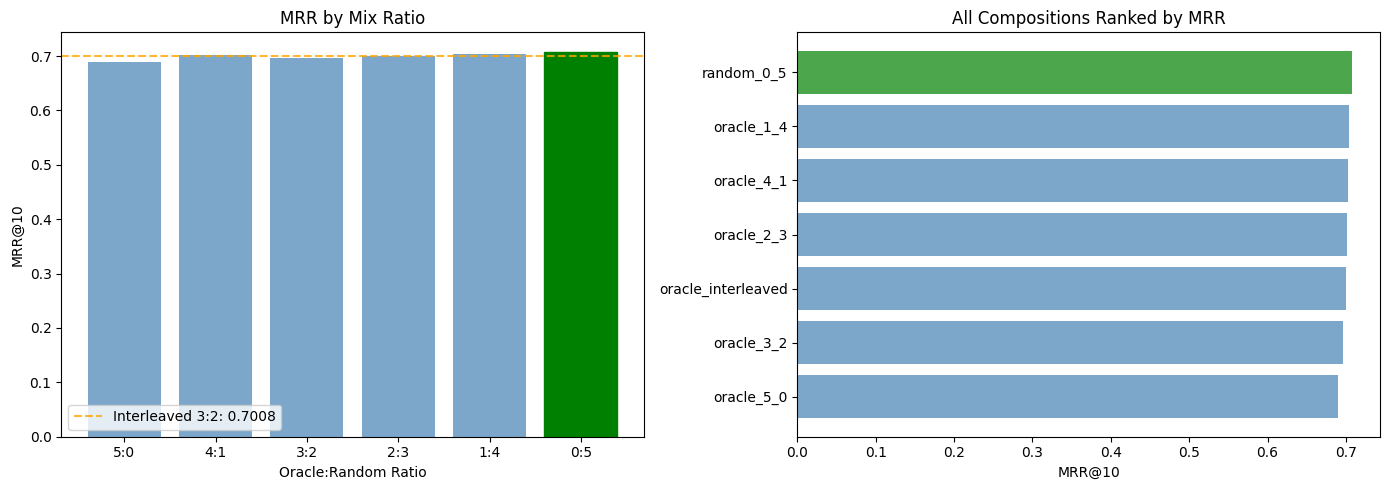


Plot saved to /home/jupyter/research/directed_kvcache/results/exp16/16_composition_results.png


In [9]:
# Cell 9: Visualize Results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MRR by mix ratio
oracle_names = ['oracle_5_0', 'oracle_4_1', 'oracle_3_2', 'oracle_2_3', 'oracle_1_4', 'random_0_5']
oracle_mrrs = [summary[n]['mrr'] for n in oracle_names if n in summary]
x_labels = ['5:0', '4:1', '3:2', '2:3', '1:4', '0:5']

ax1 = axes[0]
bars = ax1.bar(range(len(oracle_mrrs)), oracle_mrrs, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(oracle_mrrs)))
ax1.set_xticklabels(x_labels[:len(oracle_mrrs)])
ax1.set_xlabel('Oracle:Random Ratio')
ax1.set_ylabel('MRR@10')
ax1.set_title('MRR by Mix Ratio')

# Highlight the best
best_idx = oracle_mrrs.index(max(oracle_mrrs))
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(1.0)

# Add interleaved as separate point if available
if 'oracle_interleaved' in summary:
    ax1.axhline(y=summary['oracle_interleaved']['mrr'], color='orange', 
                linestyle='--', alpha=0.8, label=f"Interleaved 3:2: {summary['oracle_interleaved']['mrr']:.4f}")
    ax1.legend()

# Plot 2: All compositions ranked
ax2 = axes[1]
comp_names = [n for n, _ in sorted_comps]
mrrs = [m['mrr'] for _, m in sorted_comps]
colors = ['green' if n == best_comp[0] else 'steelblue' for n in comp_names]

ax2.barh(range(len(comp_names)), mrrs, color=colors, alpha=0.7)
ax2.set_yticks(range(len(comp_names)))
ax2.set_yticklabels(comp_names)
ax2.set_xlabel('MRR@10')
ax2.set_title('All Compositions Ranked by MRR')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(RESULTS_DIR / '16_composition_results.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nPlot saved to {RESULTS_DIR / '16_composition_results.png'}")

In [10]:
# Cell 10: Save Final Results

final_results = {
    'metadata': {
        'experiment': '16_prefix_composition',
        'timestamp': time.strftime('%Y-%m-%dT%H:%M:%S'),
        'n_pages': len(ranking_task),
        'seed': SEED
    },
    'compositions': summary,
    'best_overall': best_comp[0],
    'conclusion': {
        'optimal_ratio': None,
        'interleaving_helps': None,
        'mixing_helps': None
    }
}

# Determine optimal ratio
oracle_ratios = [
    ('oracle_5_0', 5, 0),
    ('oracle_4_1', 4, 1),
    ('oracle_3_2', 3, 2),
    ('oracle_2_3', 2, 3),
    ('oracle_1_4', 1, 4),
    ('random_0_5', 0, 5),
]
best_ratio = max([(n, summary[n]['mrr']) for n, _, _ in oracle_ratios if n in summary], key=lambda x: x[1])
final_results['conclusion']['optimal_ratio'] = best_ratio[0]

# Check if interleaving helps
if 'oracle_interleaved' in summary and 'oracle_3_2' in summary:
    interleaved_better = summary['oracle_interleaved']['mrr'] > summary['oracle_3_2']['mrr']
    final_results['conclusion']['interleaving_helps'] = interleaved_better

# Check if mixing helps (best mix beats both pure oracle and pure random)
if 'oracle_5_0' in summary and 'random_0_5' in summary:
    pure_oracle = summary['oracle_5_0']['mrr']
    pure_random = summary['random_0_5']['mrr']
    best_mrr = best_comp[1]['mrr']
    mixing_helps = best_mrr > pure_oracle and best_mrr > pure_random
    final_results['conclusion']['mixing_helps'] = mixing_helps

with open(RESULTS_DIR / '16_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Final results saved!")
print(f"\nConclusions:")
print(f"  Optimal ratio: {final_results['conclusion']['optimal_ratio']}")
print(f"  Interleaving helps: {final_results['conclusion']['interleaving_helps']}")
print(f"  Mixing helps: {final_results['conclusion']['mixing_helps']}")

Final results saved!

Conclusions:
  Optimal ratio: random_0_5
  Interleaving helps: True
  Mixing helps: False


In [11]:
# Cell 11: Per-Page Analysis - Which Pages Benefit from Mixing?

print("\n" + "="*70)
print("PER-PAGE ANALYSIS: WHO BENEFITS FROM MIXING?")
print("="*70)

# Compare pure oracle vs best mix vs pure random for each page
if 'oracle_5_0' in composition_results and 'oracle_3_2' in composition_results and 'random_0_5' in composition_results:
    oracle_pure = {r['page_idx']: r['metrics']['mrr'] for r in composition_results['oracle_5_0']}
    oracle_mix = {r['page_idx']: r['metrics']['mrr'] for r in composition_results['oracle_3_2']}
    random_pure = {r['page_idx']: r['metrics']['mrr'] for r in composition_results['random_0_5']}
    
    mix_wins_over_pure_oracle = []
    mix_wins_over_pure_random = []
    
    for page_idx in oracle_pure:
        if page_idx in oracle_mix and page_idx in random_pure:
            if oracle_mix[page_idx] > oracle_pure[page_idx] + 0.001:
                mix_wins_over_pure_oracle.append(page_idx)
            if oracle_mix[page_idx] > random_pure[page_idx] + 0.001:
                mix_wins_over_pure_random.append(page_idx)
    
    print(f"\nMix (3:2) beats pure oracle (5:0): {len(mix_wins_over_pure_oracle)} pages")
    print(f"Mix (3:2) beats pure random (0:5): {len(mix_wins_over_pure_random)} pages")
    
    # Find pages where mix is uniquely best
    mix_uniquely_best = [p for p in mix_wins_over_pure_oracle if p in mix_wins_over_pure_random]
    print(f"Mix (3:2) beats BOTH pure oracle AND pure random: {len(mix_uniquely_best)} pages")

print("\nAnalysis complete!")


PER-PAGE ANALYSIS: WHO BENEFITS FROM MIXING?

Mix (3:2) beats pure oracle (5:0): 38 pages
Mix (3:2) beats pure random (0:5): 33 pages
Mix (3:2) beats BOTH pure oracle AND pure random: 10 pages

Analysis complete!
